In [1]:
import numpy as np
from glob import glob
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from matplotlib.patches import Ellipse, Circle
from matplotlib.patheffects import withStroke
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cms

from regions import EllipseSkyRegion, RectangleSkyRegion

from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.patches import Rectangle



In [17]:
# Load the spectral cube
cube = fits.open('J1348_630_12m+7m_13co10.fits')  # Replace 'filename.fits' with your file name
data = cube[0].data  # Access the data part of the FITS file
center = SkyCoord('13h48m12.739s', '-63d16m24.7s', frame='icrs')

Shape of data: (207, 185)
Image size: 207 x 185


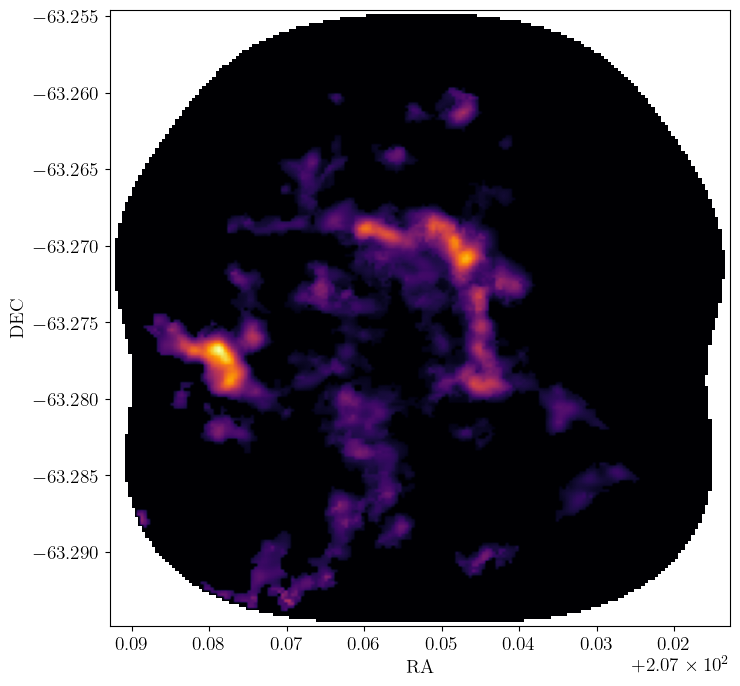

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from matplotlib.patches import Rectangle

# Load the FITS file and WCS
file_path = "J1348_630_12m+7m_13co10_strict_mom0.fits"
with fits.open(file_path) as hdul:
    header = hdul[0].header
    data = hdul[0].data

# Check the shape of the data
print("Shape of data:", data.shape)

wcs = WCS(header)

# Extract the pixel scale from the header (CDELT1 and CDELT2)
cdelt1 = header['CDELT1'] * 3600  # arcseconds per pixel in x direction
cdelt2 = header['CDELT2'] * 3600  # arcseconds per pixel in y direction

arcsec_per_pixel = np.mean([np.abs(cdelt1), np.abs(cdelt2)])

# Define the two coordinates (jet and J1348 positions)
ra_dec_jet = SkyCoord("13h48m15.03s", "-63d16m05.23s", frame='icrs')
ra_dec_J1348 = SkyCoord("13h48m12.79s", "-63d16m28.48s", frame='icrs')

# Convert the coordinates to pixel positions
pixel_jet = wcs.world_to_pixel(ra_dec_jet)
pixel_J1348 = wcs.world_to_pixel(ra_dec_J1348)

# Calculate the vector between the two points in pixels
delta_x = pixel_J1348[0] - pixel_jet[0]
delta_y = pixel_J1348[1] - pixel_jet[1]

# Find a perpendicular vector to this direction for the rectangle's width
perpendicular_x = -delta_y
perpendicular_y = delta_x

width_in_pixels = 10 / arcsec_per_pixel

# Normalize the perpendicular vector
length = np.sqrt(perpendicular_x**2 + perpendicular_y**2)
perpendicular_x = (perpendicular_x / length) * width_in_pixels
perpendicular_y = (perpendicular_y / length) * width_in_pixels

# Calculate the rectangle's corner positions using the middle point (pixel_jet)
x0 = pixel_jet[0] - perpendicular_x / 2
y0 = pixel_jet[1] - perpendicular_y / 2
width = width_in_pixels
height = np.sqrt(delta_x**2 + delta_y**2)

# Get the shape of the data
ny, nx = data.shape if len(data.shape) == 2 else data[0].shape
print(f"Image size: {ny} x {nx}")

# Get the world coordinates of the bottom-left and top-right corners
corner_world_bl = wcs.pixel_to_world(0, 0)  # Bottom-left (0, 0) pixel in world coordinates
corner_world_tr = wcs.pixel_to_world(nx, ny)  # Top-right (max_x, max_y) pixel in world coordinates

# Convert the corner world coordinates to pixel coordinates
corner_pixel_bl = [corner_world_bl.ra.deg, corner_world_bl.dec.deg]  # RA, DEC of bottom-left
corner_pixel_tr = [corner_world_tr.ra.deg, corner_world_tr.dec.deg]  # RA, DEC of top-right

# Plotting the image and the rectangle
fig, ax = plt.subplots(figsize=(8, 8))

# Check if the data needs to be indexed to get the 2D slice
image_data = data[0] if len(data.shape) > 2 else data

# Display the image data with correct extent
ax.imshow(image_data, cmap='inferno', origin='lower', aspect='auto', 
          extent=[corner_pixel_bl[0], corner_pixel_tr[0], corner_pixel_bl[1], corner_pixel_tr[1]])
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# Add the rectangle to the plot
rect = Rectangle((x0, y0), width, height, angle=np.degrees(np.arctan2(delta_y, delta_x)), 
                 linewidth=2, edgecolor='red', facecolor='red')

ax.add_patch(rect)

# Show the plot
plt.show()


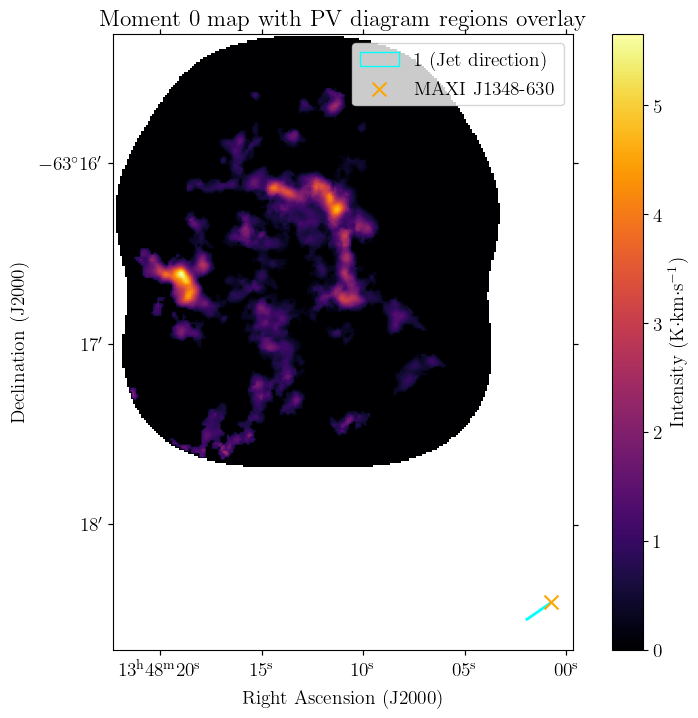

Figure saved as mom_0map_PVapertures_jetdir.pdf


In [75]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel

# Load the FITS file
file_path = "J1348_630_12m+7m_13co10_strict_mom0.fits"
with fits.open(file_path) as hdul:
    header = hdul[0].header  # Update index if data isn't in the primary HDU
    data = hdul[0].data

# Load WCS info
wcs = WCS(header)

ra_dec = {"Approaching jet direction": ("13h48m15.03s", "-63d16m05.23s", 'red')}

ra_dec_J1348 = {'MAXI J1348-630': ('13h48m12.79s', '-63d16m28.48s')}

cdelt1 = header['CDELT1']  # deg per pixel in x direction
cdelt2 = header['CDELT2']  # deg per pixel in y direction
arcsec_per_pixel = np.mean([np.abs(cdelt1), np.abs(cdelt2)])

coords = []
coordsJ1348=[]
for date, (ra, dec, color) in ra_dec.items():
    sky_coord = SkyCoord(ra, dec, frame="icrs")
    coords.append(sky_coord.ra.degree)
    coords.append(sky_coord.dec.degree)
    
for name, (ra,dec) in ra_dec_J1348.items():
    sky_coord_J1348 = SkyCoord(ra, dec, frame="icrs")
    coordsJ1348.append(sky_coord_J1348.ra.degree)
    coordsJ1348.append(sky_coord_J1348.dec.degree)


# Extract the start and end points of the line in RA/Dec
start_coord_1 = SkyCoord(ra=coordsJ1348[0], dec=coordsJ1348[1], unit="deg")  # Start point
end_coord_1 = SkyCoord(ra=coords[0], dec=coords[1], unit="deg")  # End point

# Calculate the vector between the two points in pixels
delta_ra = coordsJ1348[0] - coords[0]
delta_dec = coordsJ1348[1] - coords[1]

# Find a perpendicular vector to this direction for the rectangle's width
perpendicular_ra = -delta_dec
perpendicular_dec = delta_ra

width_in_deg = 10 / 3600 #Convert width to deg

# Normalize the perpendicular vector
length = np.sqrt(perpendicular_ra**2 + perpendicular_dec**2)
perpendicular_ra = (perpendicular_ra / length) * width_in_deg
perpendicular_dec = (perpendicular_dec / length) * width_in_deg

# Calculate the rectangle's corner positions using the middle point (pixel_jet)
x0 = coords[0] - perpendicular_ra / 2
y0 = coords[1] - perpendicular_dec / 2
width = width_in_deg
height = np.sqrt(delta_ra**2 + delta_dec**2)

# Width of the box in arcseconds
box_width_arcsec_1 = 10  # Total width
box_width_deg_1 = (box_width_arcsec_1 / 3600.0)  # Convert to degrees

# Convert the start and end coordinates to pixel values
start_pix_1 = skycoord_to_pixel(start_coord_1, wcs)
end_pix_1 = skycoord_to_pixel(end_coord_1, wcs)
#x0_pix = skycoord_to_pixel(x0,wcs)
#y0_pix = skycoord_to_pixel(y0,wcs)

# Define the rectangle center and size in pixel coordinates
x_center_1 = (start_pix_1[0] + end_pix_1[0]) / 2
y_center_1 = (start_pix_1[1] + end_pix_1[1]) / 2
box_length_pix_1 = abs(delta_ra**2+delta_dec**2)/abs(arcsec_per_pixel)  # Length of the rectangle in pixels
box_width_pix_1 = box_width_deg_1 / abs(arcsec_per_pixel)  # Convert width to pixels
anglebox = np.degrees(np.arctan2(delta_dec, delta_ra))

# Plot the moment-0 map
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs.celestial)
im = ax.imshow(data, origin="lower", cmap="inferno")
plt.colorbar(im, label="Intensity (K$\cdot$km$\cdot$s$^{-1}$)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title(f"Moment 0 map with PV diagram regions overlay")

# Overlay the rectangle
rect_1 = Rectangle(
    (coordsJ1348[0], coordsJ1348[1]),  # Bottom-left corner
    box_width_pix_1,  # Width
    box_length_pix_1,  # Height
    angle=anglebox,
    transform=ax.get_transform('pixel'),  # Ensure rectangle aligns with pixel grid
    edgecolor="cyan",
    facecolor="none",
    label="1 (Jet direction)",
    linewidth=1,
)
ax.add_patch(rect_1)

starting_coord_pix= [coordsJ1348[0], coordsJ1348[1]]
plt.scatter(*starting_coord_pix, color='orange', marker='x', s=100, label='MAXI J1348-630')

plt.legend()
plt.show()

output_filename = "mom_0map_PVapertures_jetdir.pdf"
fig.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")

ra= 207.05606639999996 ,dec= -63.27597780000001
<SkyCoord (ICRS): (ra, dec) in deg
    (207.0671253, -63.2616)>
-0.0001944444444444 0.0001944444444444
0.6999999999998401


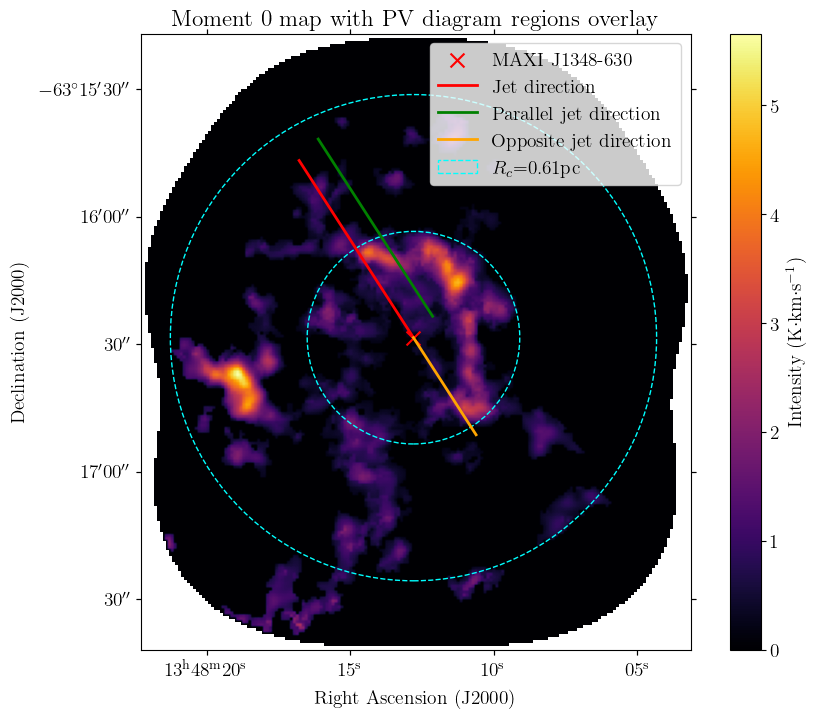

Figure saved as mom_0map_PVlines_jetdirection.pdf


In [29]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel

# Load the FITS file
file_path = "J1348_630_12m+7m_13co10_strict_mom0.fits"
with fits.open(file_path) as hdul:
    header = hdul[0].header  # Update index if data isn't in the primary HDU
    data = hdul[0].data

# Load WCS info
wcs = WCS(header)

# Plot the moment-0 map
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs.celestial)
im = ax.imshow(data, origin="lower", cmap="inferno")
plt.colorbar(im, label="Intensity (K$\cdot$km$\cdot$s$^{-1}$)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title(f"Moment 0 map with PV diagram regions overlay")

point2 = SkyCoord(ra=207.0626250, dec=-63.2681194, unit="deg")  # Start point
point1 = SkyCoord(ra=207.0532917, dec=-63.2745778, unit="deg")  # End point
point3 = SkyCoord(ra=207.0699, dec=-63.263, unit="deg")

z1=0.0166083
z2=0.0115778

point4 = SkyCoord(ra=207.050517, dec=-63.2731778, unit="deg")  # End point

deltara = 207.050517-207.0532917
deltadec = -63.2731778-(-63.2745778)

print('ra=',207.0532917-deltara, ',dec=',-63.2745778-deltadec)
point5 = SkyCoord(ra=207.0699+deltara, dec=-63.263+deltadec, unit="deg")  # End point
#point5 = SkyCoord(ra=207.0669, dec=-63.2615, unit="deg")

point6 = SkyCoord(ra=207.0441937, dec=-63.2809218, unit="deg")
point7 = SkyCoord(ra=207.0402795, dec=-63.2803153, unit="deg")


pixel1 = wcs.world_to_pixel(point1)
pixel2 = wcs.world_to_pixel(point2)
pixel3 = wcs.world_to_pixel(point3)
pixel4 = wcs.world_to_pixel(point4)
pixel5 = wcs.world_to_pixel(point5)
pixel6 = wcs.world_to_pixel(point6)
pixel7 = wcs.world_to_pixel(point7)


ax.scatter(pixel1[0], pixel1[1], color='red', s=100, marker='x', label='MAXI J1348-630')
"""
ax.scatter(pixel2[0], pixel2[1], color='blue', s=100, marker='x', label='Jet direction')
ax.scatter(pixel3[0], pixel3[1], color='orange', s=100, marker='x', label='Jet direction')
ax.scatter(pixel4[0], pixel4[1], color='yellow', s=100, marker='x', label='No Jet direction')
ax.scatter(pixel5[0], pixel5[1], color='purple', s=100, marker='x', label='No Jet direction')
"""
ax.plot([pixel1[0], pixel3[0]], [pixel1[1], pixel3[1]], color='red', linewidth=2, label='Jet direction')
ax.plot([pixel4[0], pixel5[0]], [pixel4[1], pixel5[1]], color='green', linewidth=2, label='Parallel jet direction')
ax.plot([pixel1[0], pixel6[0]], [pixel1[1], pixel6[1]], color='orange', linewidth=2, label='Opposite jet direction')
#ax.plot([pixel4[0], pixel7[0]], [pixel4[1], pixel7[1]], color='yellow', linewidth=2, label='Parallel opposing jet direction')
pixel_scale = np.abs(header['CDELT2']) * 3600

print(point5)
pixelscale1, pixelscale2 = header['CDELT1'], header['CDELT2']
print(pixelscale1, pixelscale2)
print(pixel_scale)
cavityradius = 25.0
circle_in = Circle(
    (pixel1[0],pixel1[1]), 
    radius=cavityradius/pixel_scale, 
    #radius=35.7,
    transform=ax.get_transform('pixel'), 
    edgecolor='cyan', 
    facecolor='none', 
    lw=1, 
    linestyle='--',
    label="$R_c$=0.61pc"
)
ax.add_patch(circle_in)

circle_out = Circle(
    (pixel1[0],pixel1[1]), 
    radius= 57.19/pixel_scale, 
    transform=ax.get_transform('pixel'), 
    edgecolor='cyan', 
    facecolor='none', 
    linestyle='--',
    lw=1)
ax.add_patch(circle_out)

plt.legend()
plt.show()

output_filename = "mom_0map_PVlines_jetdirection.pdf"
fig.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")

Length= 49.603494741194794



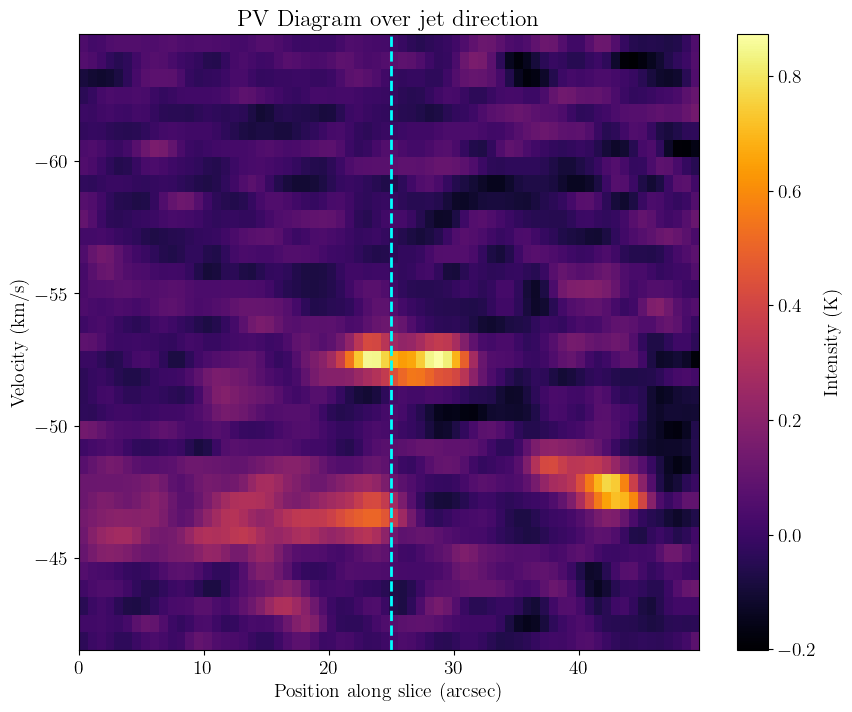

Figure saved as PVslice_jetdirection.pdf


In [21]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

# Load the spectral cube
cube = SpectralCube.read("J1348_630_12m+7m_13co10.fits")

# Extract the WCS from the cube
wcs = cube.wcs

# Define the start and end points in celestial coordinates
point3 = SkyCoord(ra=207.0699, dec=-63.263, unit="deg")
point2 = SkyCoord(ra=207.0626250, dec=-63.2681194, unit="deg")  # Start point
point1 = SkyCoord(ra=207.0532917, dec=-63.2745778, unit="deg")  # End point

delta_ra=(207.0699-207.0532917)
delta_dec=(63.2745778-63.263)
length=np.rad2deg(np.arccos(np.sin(np.deg2rad(-63.2745778))*np.sin(np.deg2rad(-63.263))+np.cos(np.deg2rad(-63.2745778))*np.cos(np.deg2rad(-63.263))*np.cos(np.deg2rad(207.0532917-207.0699))))
print('Length=',length*3600)
# Convert SkyCoord points to pixel coordinates
point1_pix = skycoord_to_pixel(point1, wcs)
point2_pix = skycoord_to_pixel(point3, wcs)

# Create a path using pixel coordinates
path = Path([point1_pix, point2_pix], width=5 * u.arcsec)  # Adjust width as needed

# Extract the PV slice
pv_slice_hdu = extract_pv_slice(cube, path)  # Returns a PrimaryHDU object

# Extract the PV data and WCS
pv_data = pv_slice_hdu.data
pv_data = pv_data[213:248,:]
pv_wcs = WCS(pv_slice_hdu.header)  # Build WCS from the header

# Compute velocity axis (linear interpolation)
n_channels = pv_data.shape[0]
v_start = -41.5362  # km/s at channel 0
v_end = -64.7889  # km/s at channel 301
velocity_axis = v_start + (v_end - v_start) * (np.arange(n_channels) / (n_channels - 1))

# Convert intensity to Kelvin if not already in Kelvin
if cube.unit != u.K:
    cube = cube.to(u.K)

# Compute spatial axis in arcseconds
spatial_extent_arcsec = length*3600  # Total spatial extent in arcseconds
n_spatial_pixels = pv_data.shape[1]
spatial_axis = np.linspace(0, spatial_extent_arcsec, n_spatial_pixels)

# Plot the PV diagram with physical units
fig1=plt.figure(figsize=(10, 8))
plt.imshow(
    pv_data,
    origin="lower",
    aspect="auto",
    cmap="inferno",
    extent=[
        spatial_axis[0], spatial_axis[-1],  # Spatial axis range (arcsec or deg)
        velocity_axis[0], velocity_axis[-1],  # Velocity axis range (km/s)
    ],
)
plt.xlabel("Position along slice (arcsec)")
plt.ylabel("Velocity (km/s)")
plt.title("PV Diagram over jet direction")
plt.colorbar(label="Intensity (K)")
plt.axvline(x=25, color='cyan', linestyle='--', linewidth=2)  # Vertical line at x = 2
plt.show()

output_filename = "PVslice_jetdirection.pdf"
fig1.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")


ra= 207.07267469999996 ,dec= -63.261599999999994



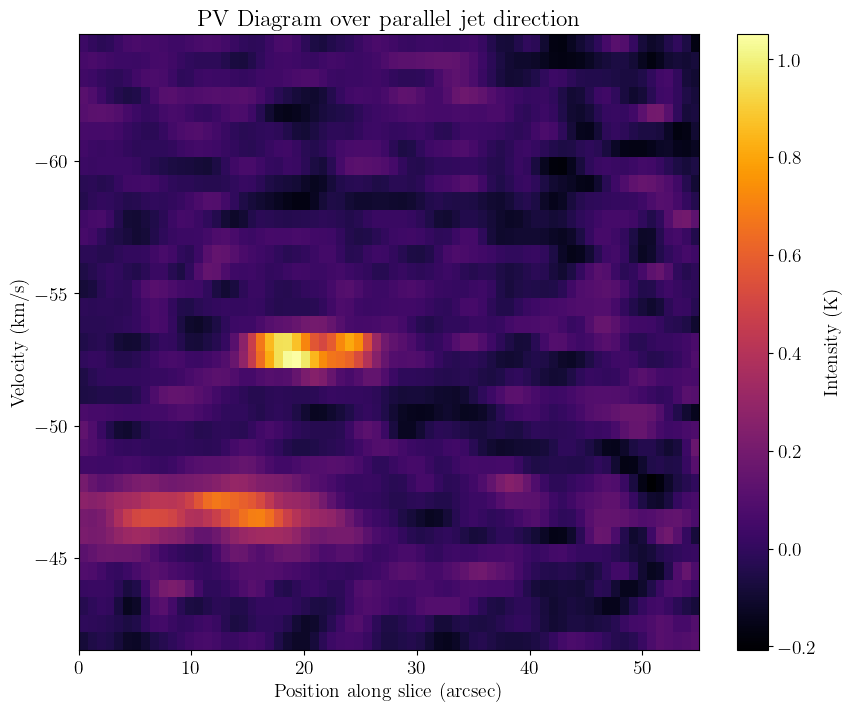

Figure saved as PVslice_paralleljetdirection.pdf


In [11]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

# Load the spectral cube
cube = SpectralCube.read("J1348_630_12m+7m_13co10.fits")

# Extract the WCS from the cube
wcs = cube.wcs

"""
# Define the start and end points in celestial coordinates
point1 = SkyCoord(ra=207.050517, dec=-63.2731778, unit="deg")  # End point
point3 = SkyCoord(ra=207.05606639999996, dec=-63.27597780000001, unit="deg")
"""
point1 = SkyCoord(ra=207.050517, dec=-63.2731778, unit="deg")  # End point

deltara = 207.050517-207.0532917
deltadec = -63.2731778-(-63.2745778)

print('ra=',207.0699-deltara, ',dec=',-63.263+deltadec)
point3 = SkyCoord(ra=207.0699+deltara, dec=-63.263+deltadec, unit="deg")

delta_ra=(207.0532917-deltara-207.050517)
delta_dec=(63.2731778+(-63.2745778-deltadec))
length=np.rad2deg(np.arccos(np.sin(np.deg2rad(-63.2731778))*np.sin(np.deg2rad(-63.261599999999994))+np.cos(np.deg2rad(-63.2731778))*np.cos(np.deg2rad(-63.261599999999994))*np.cos(np.deg2rad(207.050517-207.07267469999996))))

# Convert SkyCoord points to pixel coordinates
point1_pix = skycoord_to_pixel(point1, wcs)
point2_pix = skycoord_to_pixel(point3, wcs)

# Create a path using pixel coordinates
path = Path([point1_pix, point2_pix], width=5 * u.arcsec)  # Adjust width as needed

# Extract the PV slice
pv_slice_hdu = extract_pv_slice(cube, path)  # Returns a PrimaryHDU object

# Extract the PV data and WCS
pv_data = pv_slice_hdu.data
pv_data = pv_data[213:248,:]
pv_wcs = WCS(pv_slice_hdu.header)  # Build WCS from the header

# Compute velocity axis (linear interpolation)
n_channels = pv_data.shape[0]
v_start = -41.5362  # km/s at channel 0
v_end = -64.7889  # km/s at channel 301
velocity_axis = v_start + (v_end - v_start) * (np.arange(n_channels) / (n_channels - 1))

# Convert intensity to Kelvin if not already in Kelvin
if cube.unit != u.K:
    cube = cube.to(u.K)

# Compute spatial axis in arcseconds
spatial_extent_arcsec = length*3600  # Total spatial extent in arcseconds
n_spatial_pixels = pv_data.shape[1]
spatial_axis = np.linspace(0, spatial_extent_arcsec, n_spatial_pixels)

# Plot the PV diagram with physical units
fig2=plt.figure(figsize=(10, 8))
plt.imshow(
    pv_data,
    origin="lower",
    aspect="auto",
    cmap="inferno",
    extent=[
        spatial_axis[0], spatial_axis[-1],  # Spatial axis range (arcsec or deg)
        velocity_axis[0], velocity_axis[-1],  # Velocity axis range (km/s)
    ],
)
plt.xlabel("Position along slice (arcsec)")
plt.ylabel("Velocity (km/s)")
plt.title("PV Diagram over parallel jet direction")
plt.colorbar(label="Intensity (K)")
plt.show()

output_filename = "PVslice_paralleljetdirection.pdf"
fig2.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")

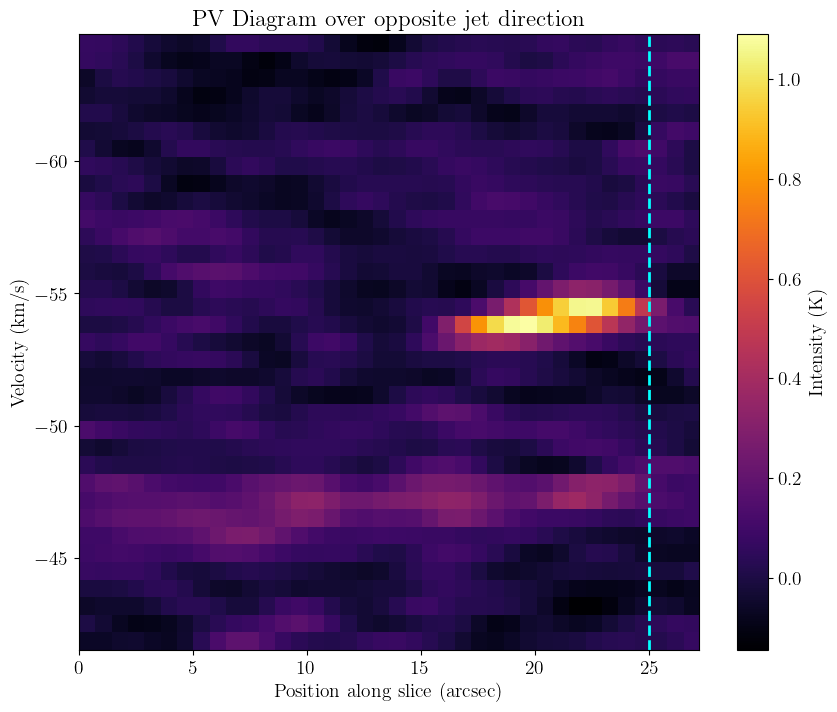

Figure saved as PVslice_oppjetdirection.pdf


In [19]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

# Load the spectral cube
cube = SpectralCube.read("J1348_630_12m+7m_13co10.fits")

# Extract the WCS from the cube
wcs = cube.wcs

# Define the start and end points in celestial coordinates
point3 = SkyCoord(ra=207.0441937, dec=-63.2809218, unit="deg")
#point2 = SkyCoord(ra=207.0626250, dec=-63.2681194, unit="deg")  # Start point
point1 = SkyCoord(ra=207.0532917, dec=-63.2745778, unit="deg")  # End point

delta_ra=(207.0441937-207.0532917)
delta_dec=(63.2745778-63.2809218)
length=np.rad2deg(np.arccos(np.sin(np.deg2rad(-63.2745778))*np.sin(np.deg2rad(-63.2809218))+np.cos(np.deg2rad(-63.2745778))*np.cos(np.deg2rad(-63.2809218))*np.cos(np.deg2rad(207.0532917-207.0441937))))


# Convert SkyCoord points to pixel coordinates
point1_pix = skycoord_to_pixel(point1, wcs)
point2_pix = skycoord_to_pixel(point3, wcs)

# Create a path using pixel coordinates
path = Path([point1_pix, point2_pix], width=5 * u.arcsec)  # Adjust width as needed

# Extract the PV slice
pv_slice_hdu = extract_pv_slice(cube, path)  # Returns a PrimaryHDU object

# Extract the PV data and WCS
pv_data = pv_slice_hdu.data
pv_data = pv_data[213:248,:]
pv_wcs = WCS(pv_slice_hdu.header)  # Build WCS from the header

# Compute velocity axis (linear interpolation)
n_channels = pv_data.shape[0]
v_start = -41.5362  # km/s at channel 0
v_end = -64.7889  # km/s at channel 301
velocity_axis = v_start + (v_end - v_start) * (np.arange(n_channels) / (n_channels - 1))

# Convert intensity to Kelvin if not already in Kelvin
if cube.unit != u.K:
    cube = cube.to(u.K)

# Compute spatial axis in arcseconds
spatial_extent_arcsec = length*3600  # Total spatial extent in arcseconds
n_spatial_pixels = pv_data.shape[1]
spatial_axis = np.linspace(0, spatial_extent_arcsec, n_spatial_pixels)

# Plot the PV diagram with physical units
fig3=plt.figure(figsize=(10, 8))
plt.imshow(
    pv_data,
    origin="lower",
    aspect="auto",
    cmap="inferno",
    extent=[
        spatial_axis[0], spatial_axis[-1],  # Spatial axis range (arcsec or deg)
        velocity_axis[0], velocity_axis[-1],  # Velocity axis range (km/s)
    ],
)
plt.xlabel("Position along slice (arcsec)")
plt.ylabel("Velocity (km/s)")
plt.title("PV Diagram over opposite jet direction")
plt.colorbar(label="Intensity (K)")
plt.axvline(x=25, color='cyan', linestyle='--', linewidth=2)  # Vertical line at x = 2
plt.show()

output_filename = "PVslice_oppjetdirection.pdf"
fig3.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")


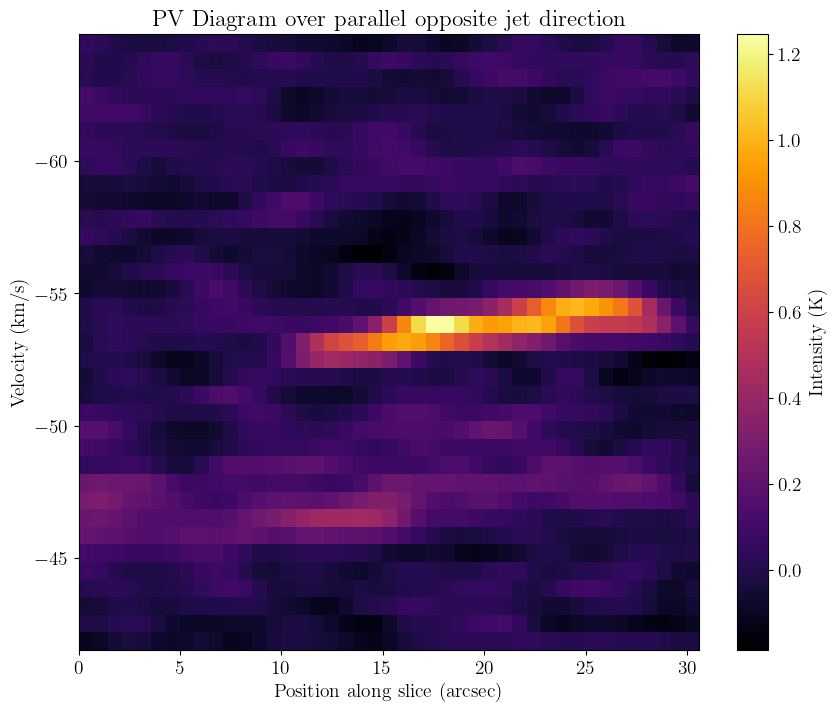

Figure saved as PVslice_oppparalleljetdirection.pdf


In [15]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

# Load the spectral cube
cube = SpectralCube.read("J1348_630_12m+7m_13co10.fits")

# Extract the WCS from the cube
wcs = cube.wcs

"""
# Define the start and end points in celestial coordinates
point1 = SkyCoord(ra=207.050517, dec=-63.2731778, unit="deg")  # End point
point3 = SkyCoord(ra=207.05606639999996, dec=-63.27597780000001, unit="deg")
"""
point1 = SkyCoord(ra=207.050517, dec=-63.2731778, unit="deg")  # End point

point3 = SkyCoord(ra=207.0402795, dec=-63.2803153, unit="deg")

delta_ra=(207.0402795-207.050517)
delta_dec=(63.2731778+(-63.2803153))
length=np.rad2deg(np.arccos(np.sin(np.deg2rad(-63.2731778))*np.sin(np.deg2rad(-63.2803153))+np.cos(np.deg2rad(-63.2731778))*np.cos(np.deg2rad(-63.2803153))*np.cos(np.deg2rad(207.050517-207.0402795))))


# Convert SkyCoord points to pixel coordinates
point1_pix = skycoord_to_pixel(point1, wcs)
point2_pix = skycoord_to_pixel(point3, wcs)

# Create a path using pixel coordinates
path = Path([point1_pix, point2_pix], width=5 * u.arcsec)  # Adjust width as needed

# Extract the PV slice
pv_slice_hdu = extract_pv_slice(cube, path)  # Returns a PrimaryHDU object

# Extract the PV data and WCS
pv_data = pv_slice_hdu.data
pv_data = pv_data[213:248,:]
pv_wcs = WCS(pv_slice_hdu.header)  # Build WCS from the header

# Compute velocity axis (linear interpolation)
n_channels = pv_data.shape[0]
v_start = -41.5362  # km/s at channel 0
v_end = -64.7889  # km/s at channel 301
velocity_axis = v_start + (v_end - v_start) * (np.arange(n_channels) / (n_channels - 1))

# Convert intensity to Kelvin if not already in Kelvin
if cube.unit != u.K:
    cube = cube.to(u.K)

# Compute spatial axis in arcseconds
spatial_extent_arcsec = length*3600  # Total spatial extent in arcseconds
n_spatial_pixels = pv_data.shape[1]
spatial_axis = np.linspace(0, spatial_extent_arcsec, n_spatial_pixels)

# Plot the PV diagram with physical units
fig4=plt.figure(figsize=(10, 8))
plt.imshow(
    pv_data,
    origin="lower",
    aspect="auto",
    cmap="inferno",
    extent=[
        spatial_axis[0], spatial_axis[-1],  # Spatial axis range (arcsec or deg)
        velocity_axis[0], velocity_axis[-1],  # Velocity axis range (km/s)
    ],
)
plt.xlabel("Position along slice (arcsec)")
plt.ylabel("Velocity (km/s)")
plt.title("PV Diagram over parallel opposite jet direction")
plt.colorbar(label="Intensity (K)")
plt.show()

output_filename = "PVslice_oppparalleljetdirection.pdf"
fig4.savefig(
    output_filename,
    dpi=300,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata={"Creator": "Matplotlib"},
)


print(f"Figure saved as {output_filename}")